<a href="https://colab.research.google.com/github/Naveen11205570/Computer-Vision-and-Deep-Learning/blob/main/Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **Fine-tuning a Pretrained ResNet Model for Image Classification**

In this assignment, we will explore the concept of transfer learning by fine-tuning a pretrained ResNet model for the task of image classification. ResNet, or Residual Network, is a deep convolutional neural network architecture that has achieved state-of-the-art performance on a variety of visual recognition tasks. Pretrained models are models that have been previously trained on large datasets, such as ImageNet, and can serve as a starting point for new tasks by leveraging learned features. By fine-tuning the pretrained ResNet, we aim to adapt its feature representations to a new dataset, improving both training efficiency and model performance. This process involves adjusting the model’s final layers to suit the specific classification problem, while retaining the learned features from earlier layers. At the end we compare the prformance of the pre-trained model with that of the fine-tuned model.

====================================================================================================

<style>
blue {
  color: skyblue;
}

red {
  color: red;
}

green {
  color: lightgreen;
}
</style>

### **Step - 1**
1) <blue>**torch**</blue>: This imports the <green>**PyTorch library**</green>, which is essential for building and training neural networks.
2) <blue>**torch.nn**</blue>: Imports the <green>**neural network module**</green> of PyTorch, which contains various layers and loss functions used to build models.
3) <blue>**torch.optim**</blue>: This imports the <green>**optimization algorithms**</green> module, used for updating the model's weights based on the computed gradients during training.
4) <blue>**torchvision -> datasets, models, transforms**</blue>: Imports functions from <green>**Torchvision**</green> for accessing popular datasets, pre-trained models, and transformations for image preprocessing.
5) <blue>**torchvision.utils -> make_grid**</blue>: This function is used to <green>**visualize multiple images**</green> in a grid format, useful for displaying image batches.
6) <blue>**torch.utils.data -> DataLoader**</blue>: Imports the <green>**DataLoader**</green> class, which allows for efficient loading and batching of datasets during training and testing.
7) <blue>**matplotlib.pyplot**</blue>: This imports <green>**Matplotlib**</green>, which is used for plotting and visualizing images or training metrics such as loss and accuracy.
8) <blue>**numpy**</blue>: Imports <green>**NumPy**</green> for handling arrays and performing numerical operations, which are often useful in preprocessing and analyzing data.
9) <blue>**time**</blue>: This allows tracking <green>**elapsed time**</green> during the training process, often used to measure performance.
10) <blue>**os**</blue>: Imports <green>**OS module**</green> to handle tasks like creating directories, managing file paths, or interacting with the file system.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import os
!pip install kagglehub
import kagglehub
import zipfile

In [ ]:
jessicali9530_caltech256_path = kagglehub.dataset_download('jessicali9530/caltech256')

print('Data source import complete.')

Data source import complete.


<style>
blue {
  color: skyblue;
}

red {
  color: red;
}

green {
  color: lightgreen;
}
</style>

### **Step - 2**
1) <blue>**device**</blue>: This variable checks if a <green>**CUDA-capable GPU**</green> is available; if so, it sets the device to GPU (cuda), otherwise, it falls back to the <green>**CPU**</green>.
2) <blue>**transforms.Compose**</blue>: This creates a series of <green>**transformations for training images**</green>, applied in the specified order to augment the data and prepare it for the model.
3) <blue>**transforms.Grayscale(num_output_channels=3)**</blue>: This transformation converts input images from grayscale to <green>**RGB**</green> by creating 3 output channels, which is necessary for models expecting RGB inputs.
4) <blue>**transforms.RandomResizedCrop(224)**</blue>: This randomly crops the input image to a size of <green>**224x224 pixels**</green>, introducing variation in the training data to improve model generalization.
5) <blue>**transforms.RandomHorizontalFlip()**</blue>: This randomly flips the image horizontally with a 50% chance, providing additional <green>**data augmentation**</green> for the training dataset.
6) <blue>**transforms.ToTensor()**</blue>: Converts the PIL image or NumPy array into a <green>**PyTorch tensor**</green>, which is the required input format for models.
7) <blue>**transforms.Normalize()**</blue>: This normalizes the tensor with mean and standard deviation values specified for each channel, helping the model to <green>**converge faster**</green> and perform better by ensuring the input data has a consistent scale.
8) <blue>**transforms.Resize(256)**</blue>: This resizes the input image to a height and width of <green>**256 pixels**</green>, ensuring consistency in input size before cropping.
9) <blue>**transforms.CenterCrop(224)**</blue>: This crops the center of the image to <green>**224x224 pixels**</green>, focusing on the most important part of the image for testing.

In [ ]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformations for training and testing
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels (RGB)
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels (RGB)
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

<style>
blue {
  color: skyblue;
}

red {
  color: red;
}

green {
  color: lightgreen;
}
</style>

### **Step - 3**
1) This code outlines loading the <blue>**Caltech-256**</blue> dataset for <green>**image classification**</green>.
2) The <blue>**train_loader**</blue> and <blue>**test_loader**</blue> are used to load the datasets in batches of 32, with shuffling applied only to the training set.



In [ ]:

jessicali9530_caltech256_path = kagglehub.dataset_download('jessicali9530/caltech256')
dataset_path = os.path.join(jessicali9530_caltech256_path, '256_ObjectCategories')

if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset path '{dataset_path}' does not exist.")


full_dataset = datasets.ImageFolder(dataset_path, transform=transform_train)

# Split the dataset into train and test sets (80% train, 20% test)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print('Data loading and splitting complete.')

Data loading and splitting complete.


In [ ]:
print(os.listdir('/content/'))

['.config', 'sample_data']


<style>
blue {
  color: skyblue;
}

red {
  color: red;
}

green {
  color: lightgreen;
}
</style>

### **Step - 4**
1) <blue>**model = None**</blue>: This line will load a <green>**pre-trained ResNet-18 model**</green> from the Torchvision library, which has been trained on the ImageNet dataset, allowing for transfer learning, when None is replaced with proper code.
2) <blue>**for param in model.parameters()**:</blue>: This loop iterates over all the parameters of the model, enabling modifications to their properties.
3) <blue>**param.requires_grad = None**</blue>: Inside the loop, this line will be used to <green>**freeze the model weights**</green> for all layers except the final fully connected layer. By setting requires_grad to False, gradients will not be calculated for these parameters during backpropagation, preventing them from being updated during training, when None is replace by proper code
4) <blue>**num_ftrs = model.fc.in_features**</blue>: This line retrieves the number of input features from the final fully connected layer of the model, which is necessary for modifying that layer.
5) <blue>**model.fc = nn.Linear(num_ftrs, 257)**</blue>: This modifies the final fully connected layer to output <green>**257 classes**</green>, corresponding to the number of classes in the Caltech-256 dataset, replacing the original output layer.



In [ ]:
# TODO: Replace None with correct code for loading a pretrained Resnet-18 model
model = models.resnet18(pretrained=True)

# Freeze the model weights except for the final layer
for param in model.parameters():
    # TODO: Freeze the model weights
    param.requires_grad = False

# Modify the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 257)  # 257 classes in Caltech-256

<style>
blue {
  color: skyblue;
}

red {
  color: red;
}

green {
  color: lightgreen;
}
</style>

### **Step - 5**
1) <blue>**model = None**</blue>: This line sends the <green>**model to the appropriate device**</green>, whether it's a GPU (if available) or a CPU, ensuring that the computations happen on the selected hardware, when None is replace with correct code.
2) <blue>**criterion = None**</blue>: Defines the <green>**loss function**</green> as cross-entropy loss, which is commonly used for multi-class classification problems, when None is replaced with the correct code.
3) <blue>**optimizer = None**</blue>: Initialize the <green>**Adam optimizer**</green> to update only the parameters of the modified final layer (model.fc). Set the learning rate to <green>**0.001**</green> to control the step size for each update during training.




In [ ]:
# TODO: Replace None with correct code to send model to device
model = model.to(device)

# Define loss function and optimizer
# TODO: Use a suitable loss criterion and optimizer with learning rate 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

<style>
blue {
  color: skyblue;
}

red {
  color: red;
}

green {
  color: lightgreen;
}
</style>

### **Step - 6**
1) <blue>**train_model**</blue>: This function trains and evaluates the model for a specified number of <green>**epochs**</green>.
2) It <green>**alternates**</green> between training and testing phases, setting the model to <blue>**train() or eval()**</blue> mode accordingly.
3) <blue>**images = None, labels = None**</blue>: Images and labels are moved to the <green>**device (CPU or GPU)**</green>.
4) <blue>**Backpropagation and Optimization**</blue>: Gradients are calculated using backpropagation, and the optimizer <green>**updates the model parameters**</green> based on these gradients.




In [ ]:
# Train and evaluate the model
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and testing phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluation mode
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                # TODO: Move images and labels to the device
                images = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):

                    # TODO: Forward Pass
                    outputs = model(images)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model


# Fine-tune the model
fine_tuned_model = train_model(model, criterion, optimizer, num_epochs=5)

Epoch 0/4
----------
train Loss: 3.0586 Acc: 0.3986
test Loss: 1.9801 Acc: 0.5550
Epoch 1/4
----------
train Loss: 1.8342 Acc: 0.5870
test Loss: 1.6790 Acc: 0.6098
Epoch 2/4
----------
train Loss: 1.6367 Acc: 0.6187
test Loss: 1.6820 Acc: 0.6034
Epoch 3/4
----------
train Loss: 1.5475 Acc: 0.6378
test Loss: 1.6244 Acc: 0.6214
Epoch 4/4
----------
train Loss: 1.4998 Acc: 0.6468
test Loss: 1.6283 Acc: 0.6202


<style>
blue {
  color: skyblue;
}

red {
  color: red;
}

green {
  color: lightgreen;
}
</style>

### **Step - 7**
The provided code consists of three functions designed for model evaluation and visualization:
1) <blue>**visualize_predictions**</blue>: This function takes a <green>**trained model**</green> and a <green>**dataloader**</green>, then displays a set number of images with their predicted labels. It sets the model to <blue>**evaluation mode**</blue> and processes the input data without <green>**calculating gradients**</green> (using <blue>**torch.no_grad()**</blue>), which speeds up the evaluation. After moving the inputs to the correct device, it computes predictions using a forward pass through the model and visualizes the results in a subplot.
2) <blue>**denormalize**</blue>: This utility function converts a <blue>**normalized image tensor**</blue> back to its <blue>**original form**</blue> by <green>**reversing the normalization process**</green>. It applies the <green>**mean**</green> and <green>**standard deviation**</green> used during image preprocessing, ensuring the values are scaled back into the range suitable for visualization (<blue>**clipped between 0 and 1**</blue>).
3) <blue>**make_map_classes**</blue>: This function generates a <blue>**dictionary mapping class indices**</blue> to their corresponding class names. It reads the folder names (assuming they follow a specific naming convention), extracts the index and name of each class, and sorts them in the correct order for use in classification tasks.

In [ ]:
# Evaluate the performance of the model before and after fine-tuning
# Function to visualize images and their predictions
def visualize_predictions(model, dataloader, num_images=2):
    model.eval()  # Set the model to evaluation mode
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for inputs, labels in dataloader:
            # TODO: Move images to the device
            inputs = inputs.to(device)

            # TODO: Forward Pass = Get Predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {preds[i].item()}')
                img = inputs.cpu().data[i]
                img = img.permute(1, 2, 0).numpy()  # Convert from Tensor format
                img = np.clip(img, 0, 1)  # Clip the values for display
                ax.imshow(img)

                if images_so_far == num_images:
                    return

# Function to denormalize the image for visualization
def denormalize(image_tensor):
    # Means and stds used for normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert tensor to HWC
    image = std * image + mean  # Denormalize
    image = np.clip(image, 0, 1)  # Clip values to be in [0, 1] range
    return image


def make_map_classes(path):
    classes_dir = os.listdir(path)
    classes_dir.sort()
    classes_dict = {}
    for c in classes_dir:
        index = int(c[:3])
        name = c[4:]
        classes_dict[index] = name

    return classes_dict

<style>
blue {
  color: skyblue;
}

red {
  color: red;
}

green {
  color: lightgreen;
}
</style>

### **Step - 8**
1) This function, <blue>**compare_predictions**</blue>, is designed to visually compare the predictions made by a <green>**pre-trained model**</green> and a <green>**fine-tuned version**</green> of that model, helping to assess the impact of fine-tuning. It takes in both models, a dataloader, the directory path containing class labels, and the number of images to display.
2) <blue>**Model Evaluation Mode**</blue>: Both the <green>**pre-trained**</green> and <green>**fine-tuned models**</green> are set to <green>**evaluation mode**</green> using <blue>**.eval()**</blue>. This ensures that no gradients are calculated during the forward pass, making inference faster and memory-efficient.
3)  The TODO lines highlight the need to move the <blue>**input images (inputs)**</blue> to the appropriate device (<green>**CPU**</green> or <green>**GPU**</green>), though this is left as an implementation detail.
4) The first subplot shows the prediction from the <blue>**pre-trained model**</blue> along with its <green>**corresponding class name (retrieved from**</green> the <blue>**classes_dict dictionary**</blue>). The second subplot shows the prediction from the <blue>**fine-tuned model**</blue> for comparison. This allows easy visual inspection of how fine-tuning has affected the model's ability to make accurate predictions.

In [ ]:
# Function to compare predictions of non-finetuned and finetuned models
def compare_predictions(pretrained_model, finetuned_model, dataloader, path_dir, num_images=5):
    pretrained_model.eval()
    finetuned_model.eval()

    images_shown = 0
    classes_dict = make_map_classes(path_dir)

    with torch.no_grad():
        for inputs, labels in dataloader:
            # TODO: Move inputs to device
            inputs = inputs.to(device)

            # Predictions from pre-trained model (without fine-tuning)
            # TODO: Calculate outputs using forward pass of pretrained model
            pre_outputs = pretrained_model(inputs)
            _, pre_preds = torch.max(pre_outputs, 1)

            # Predictions from fine-tuned model
            # TODO: Calculate the outputs using the gforward pass of the finetuned model
            fin_outputs = finetuned_model(inputs)
            _, fin_preds = torch.max(fin_outputs, 1)

            for i in range(inputs.size()[0]):
                if images_shown == num_images:
                    return  # Stop after showing num_images
                images_shown += 1

                img = denormalize(inputs.cpu().data[i])

                plt.figure(figsize=(10, 4))

                # Show pre-trained model's prediction
                plt.subplot(1, 2, 1)
                plt.imshow(img)
                plt.title(f'Pre-trained Prediction: {pre_preds[i].item()} : {classes_dict[pre_preds[i].item()]}')
                plt.axis('off')

                # Show fine-tuned model's prediction
                plt.subplot(1, 2, 2)
                plt.imshow(img)
                plt.title(f'Fine-tuned Prediction: {fin_preds[i].item()} : {classes_dict[fin_preds[i].item()+1]}')
                plt.axis('off')

                plt.show()

<style>
blue {
  color: skyblue;
}

red {
  color: red;
}

green {
  color: lightgreen;
}
</style>

### **Step - 9**
This code snippet is used to <green>**evaluate**</green> and visualize the predictions of both a <blue>**pre-trained**</blue> and a <blue>**fine-tuned model**</blue> on a set of example images. It compares the predictions side by side to assess the <green>**performance improvements**</green> brought by fine-tuning.

Comparing predictions of pre-trained and fine-tuned models on example images...


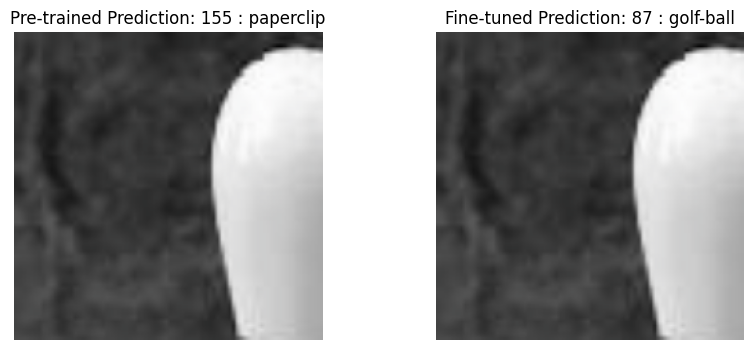

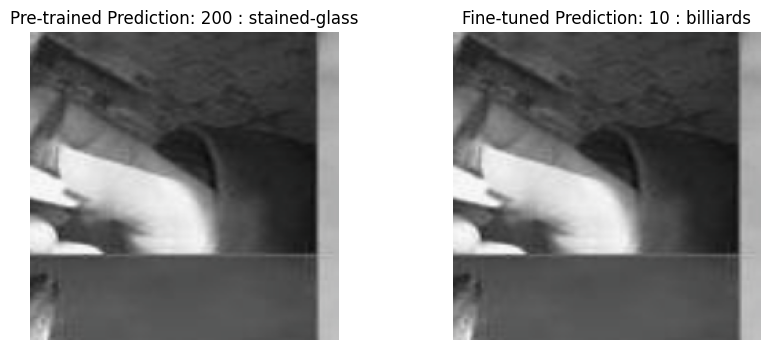

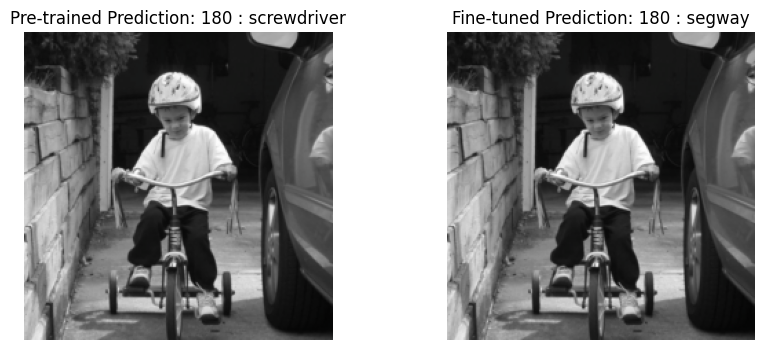

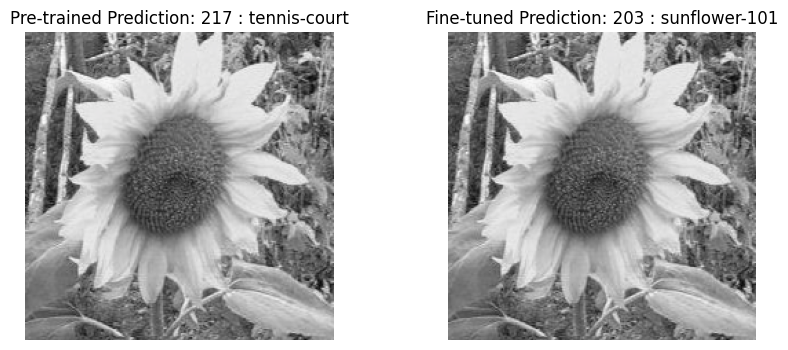

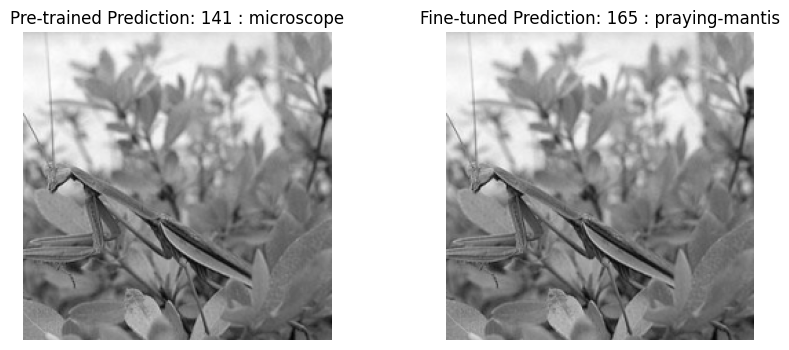

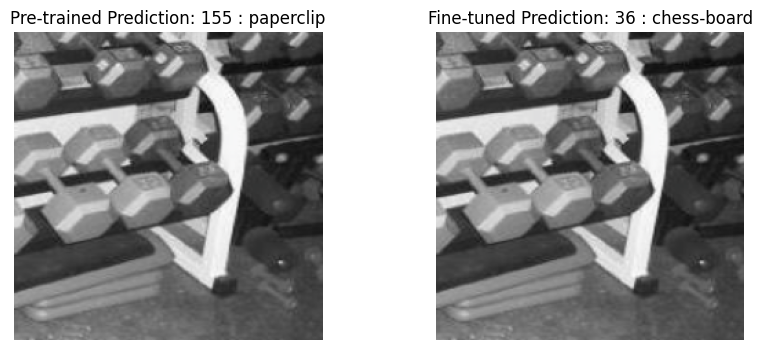

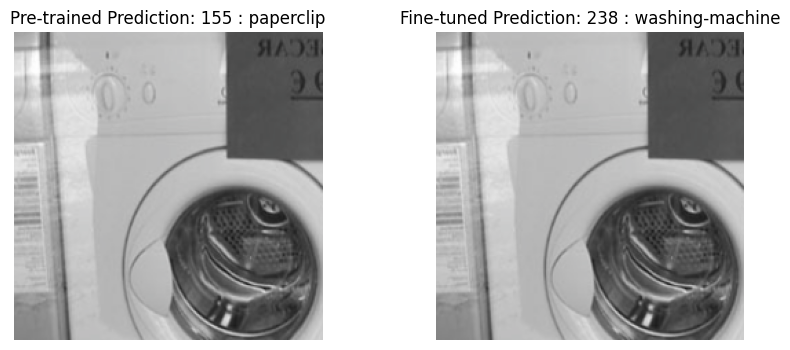

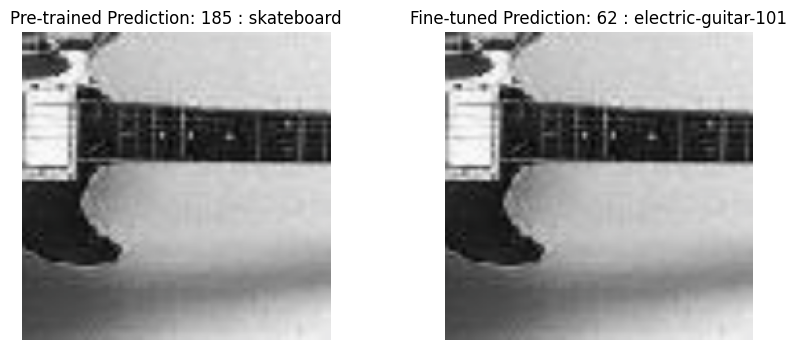

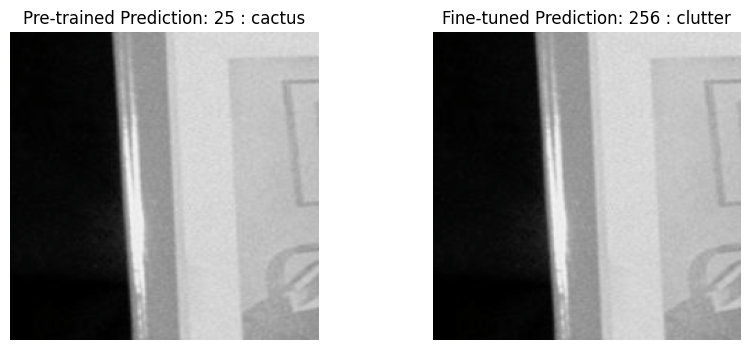

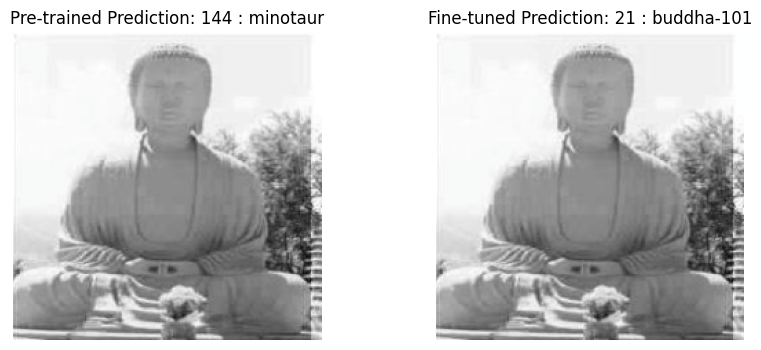

In [ ]:
# Evaluate and visualize predictions
print("Comparing predictions of pre-trained and fine-tuned models on example images...")

pretrained_model = models.resnet18(pretrained=True)
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, 257)
pretrained_model = pretrained_model.to(device)

import os
if not os.path.exists(dataset_path):
    print(f"Error: Directory not found: {dataset_path}")
    print("Please make sure the path is correct and the directory exists.")
else:
    compare_predictions(pretrained_model, fine_tuned_model, test_loader, dataset_path, num_images=10)